In [2]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [3]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec

In [4]:
api = wandb.Api(timeout=19)

In [5]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [6]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

In [7]:
bright_factor = 0.75
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
runs_dict["runs_homeostasis"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bright_factor,"config.homeostasis": 1, "config.normtype": 0,
                                                                "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")

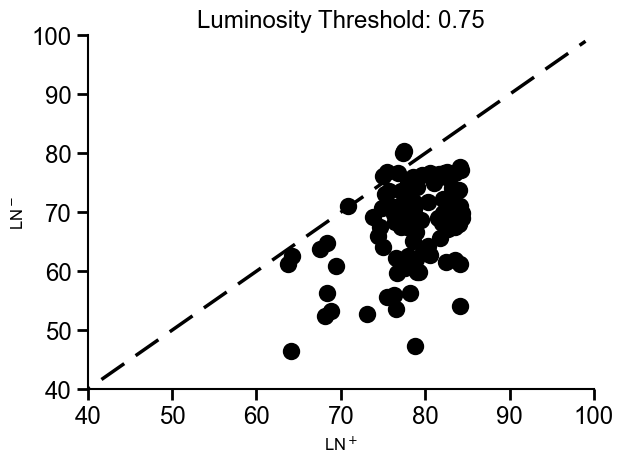

In [46]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black")




ax.set_xlabel(f"LN$^+$")
ax.set_ylabel("LN$^-$")
ax.set_title(f"Luminosity Threshold: {bright_factor}")
list_line = range(100)
ax.set_xlim(40, 100)
ax.set_ylim(40, 100)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')

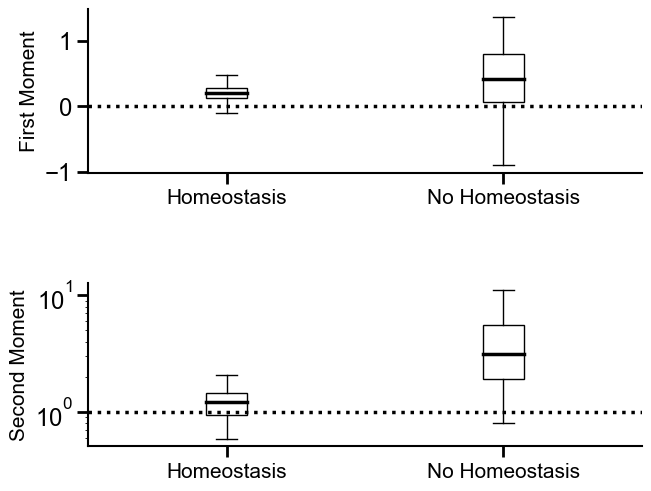

In [71]:
fig = plt.figure(layout="constrained")

plt.rcParams['figure.constrained_layout.use'] = False


gs1 = gridspec.GridSpec(2, 1, figure=fig)
ax1 = fig.add_subplot(gs1[0])
ax2 = fig.add_subplot(gs1[1])

mu_dann = []

mu_dann.append([run_van.summary['eval_fc1_mu'] for run_van in runs_dict["runs_homeostasis"]])

mu_dann.append([run_van.summary['eval_fc1_mu'] for run_van in runs_dict["runs_vanilla_dann"]])

var_dann = []

var_dann.append([run_van.summary['eval_fc1_var'] for run_van in runs_dict["runs_homeostasis"]])

var_dann.append([run_van.summary['eval_fc1_var'] for run_van in runs_dict["runs_vanilla_dann"]])


ax1.boxplot(np.array(mu_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

ax2.boxplot(np.array(var_dann).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                            showfliers=False)

# Create custom x-axis tick labels
custom_xticks = ["Homeostasis", "No Homeostasis"]
ax1.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax1.set_xticklabels(custom_xticks, fontsize=15)
ax1.axhline(y=0, color='black', linestyle='dotted')
ax2.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax2.set_xticklabels(custom_xticks, fontsize=15)
ax2.axhline(y=1, color='black', linestyle='dotted')

ax1.set_ylabel('First Moment', fontsize=15)
ax2.set_ylabel('Second Moment', fontsize=15)
#ax.legend([bp3["medians"][0]], ['H'], loc='lower left')
ax2.set_yscale('log')

gs1.tight_layout(fig, rect=[0, 0, 0.5, 1.0])

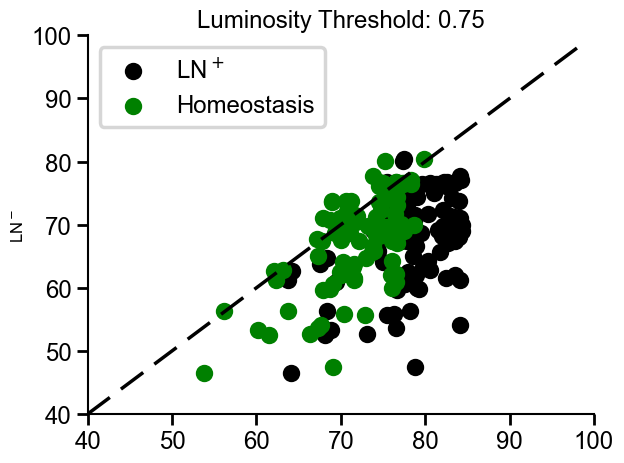

In [90]:
fig, ax = plt.subplots()

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black", alpha=1, label=f"LN$^+$" if label_flag else None)
            label_flag = False

label_flag = True
for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']
    for rn in runs_dict["runs_homeostasis"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="green", label=f"Homeostasis" if label_flag else None)
            label_flag = False



#ax.set_xlabel(f"LN$^+$")
ax.set_ylabel("LN$^-$")
ax.set_title(f"Luminosity Threshold: {bright_factor}")
list_line = range(100)
ax.set_xlim(40, 100)
ax.set_ylim(40, 100)
ax.plot(list_line, list_line, color='black', linestyle='--')
ax.legend()

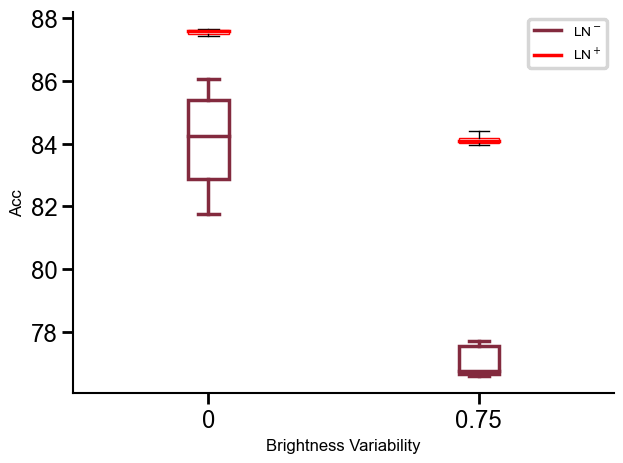

In [26]:
fig, ax = plt.subplots()
brightness_factor = [0, 0.75]
noln_acc = []
ln_acc = []
homeo_acc = []
homeo_ln_acc = []
homeo_inhib_acc = []

top_n_architectures = 10

for bf in brightness_factor:

    runs_vanilla_dann = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 0,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_vanilla_dann_layernorm = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 1,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_homeostasis = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bf,"config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc") [:top_n_architectures]
    
                                                                
    noln_acc.append([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ])
    ln_acc.append([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm])
    homeo_inhib_acc.append([run_ln.summary['test_acc'] for run_ln in runs_homeostasis])

bp1 = ax.boxplot(np.array(noln_acc).T, patch_artist=True, boxprops=dict(color='black', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='black'),
                         showbox=True, showfliers=False)
bp2 = ax.boxplot(np.array(ln_acc).T, patch_artist=True, boxprops=dict(color='red', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='red'),
                          showfliers=False)
# bp5 = ax.boxplot(np.array(homeo_inhib_acc).T, patch_artist=True, boxprops=dict(color='green', facecolor='none'), medianprops=dict(linestyle='-', linewidth=2.5, color='green'),
#                          showfliers=False)

# Iterate through each part of the boxplot and customize
for i, box in enumerate(bp5['boxes']):
    box.set(color='green', linewidth=2.5)  # Box outline color
    box.set(facecolor='none')  # Box fill color (optional)

for whisker in bp5['whiskers']:
    whisker.set(color='green', linewidth=2.5)  # Whisker (tail) color and thickness

for cap in bp5['caps']:
    cap.set(color='green', linewidth=2.5)  # Cap (end of whiskers) color and thickness

for median in bp5['medians']:
    median.set(color='green', linewidth=2.5)  # Median color and thickness

for flier in bp5['fliers']:
    flier.set(marker='o', color='green', alpha=0.5)  # Outliers (fliers) customization


color_no_ln = '#832a3e'

# Iterate through each part of the boxplot and customize
for i, box in enumerate(bp1['boxes']):
    box.set(color=color_no_ln, linewidth=2.5)  # Box outline color
    box.set(facecolor='white')  # Box fill color (optional)

for whisker in bp1['whiskers']:
    whisker.set(color=color_no_ln, linewidth=2.5)  # Whisker (tail) color and thickness

for cap in bp1['caps']:
    cap.set(color=color_no_ln, linewidth=2.5)  # Cap (end of whiskers) color and thickness

for median in bp1['medians']:
    median.set(color=color_no_ln, linewidth=2.5)  # Median color and thickness

for flier in bp1['fliers']:
    flier.set(marker='o', color=color_no_ln, alpha=0.5)  # Outliers (fliers) customization

# Create custom x-axis tick labels
custom_xticks = ['0', '0.75']
ax.set_xticks(np.arange(1, len(custom_xticks) + 1))
ax.set_xticklabels(custom_xticks)

ax.set_xlabel('Brightness Variability')
ax.set_ylabel(f'Acc')
# ax.legend([bp1["medians"][0], bp2["medians"][0], bp3["medians"][0], bp4["medians"][0]], ['LN$^-$', 'LN$^+$', f'H ($\lambda=${lmbda}) LN$^-$', f'H ($\lambda=${lmbda}) LN$^+$'], loc='lower left')
ax.legend([bp1["medians"][0], bp2["medians"][0]], ['LN$^-$', 'LN$^+$'], fontsize="10", loc ="best")
#ax.set_yscale('log')




/tmp/ipykernel_1399718/211188072.py:37: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='#eb3920')


Text(0, 0.5, 'Median Accuracy (Top 10 architectures)')

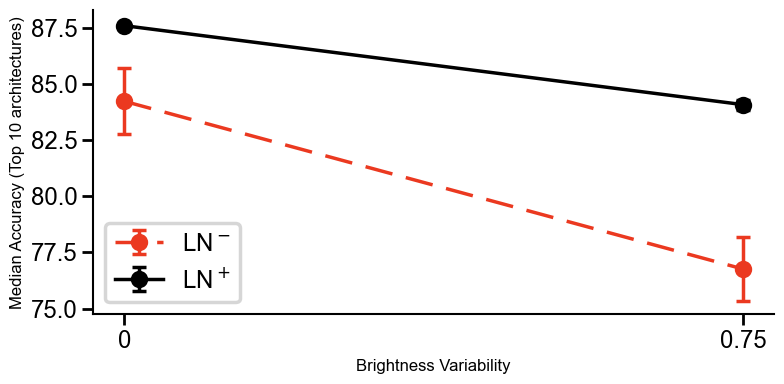

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
brightness_factor = [0, 0.75]
noln_acc = []
ln_acc = []
homeo_inhib_acc = []
noln_err = []
ln_err = []
homeo_inhib_err = []

top_n_architectures = 10

for bf in brightness_factor:

    runs_vanilla_dann = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 0,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_vanilla_dann_layernorm = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                "config.brightness_factor": bf, "config.homeostasis": 0, "config.normtype": 1,
                                                                "config.use_testset": True}, order="-summary_metrics.test_acc")[:top_n_architectures]
    runs_homeostasis = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                                    "config.brightness_factor": bf,"config.homeostasis": 1, "config.normtype": 0,
                                                                    "config.use_testset": True, "config.task_opt_inhib": 1, "config.use_sep_bias_gain_lrs": 0,
                                                                    "config.homeostatic_annealing": 0, "config.implicit_homeostatic_loss": 0 }, order="-summary_metrics.test_acc")[:top_n_architectures]
    
                                                                
    noln_acc.append(np.median([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    homeo_inhib_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))
    noln_err.append(np.std([run_noln.summary['test_acc'] for run_noln in runs_vanilla_dann ]))
    ln_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_vanilla_dann_layernorm]))
    homeo_inhib_err.append(np.std([run_ln.summary['test_acc'] for run_ln in runs_homeostasis]))

# ax.plot(range(len(noln_acc)), noln_acc, color='red')
# ax.plot(range(len(homeo_inhib_acc)), homeo_inhib_acc, color='blue')


ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='#eb3920')
#ax.errorbar(range(len(homeo_inhib_acc)), homeo_inhib_acc, yerr=homeo_inhib_err, fmt='-o', label='Homeostasis', capsize=5, color='green')
ax.errorbar(range(len(ln_acc)), ln_acc, yerr=ln_err, fmt='-o',  label='LN$^+$', capsize=5, color='black')
plt.xticks(range(len(noln_acc)), [str(ele) for ele in brightness_factor])
plt.legend()


ax.set_xlabel('Brightness Variability')
ax.set_ylabel(f'Median Accuracy (Top {top_n_architectures} architectures)')


